In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

## Retrieving the data

In [3]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, filepath):
    loaded = list()
    for name in filenames:
        data = load_file(filepath + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group):
    # load all 9 files as a single array
    filepath = "UCI HAR Dataset/UCI HAR Dataset/" + group + "/Inertial Signals/"
    filenames = os.listdir(filepath)
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file("UCI HAR Dataset/UCI HAR Dataset/" + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset():
    # load all train
    trainX, trainy = load_dataset_group('train')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    # trainy = to_categorical(trainy)
    # testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [4]:
trainX, trainy, testX, testy = load_dataset()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 1) (2947, 128, 9) (2947, 1)


Distribution of activities in the training set

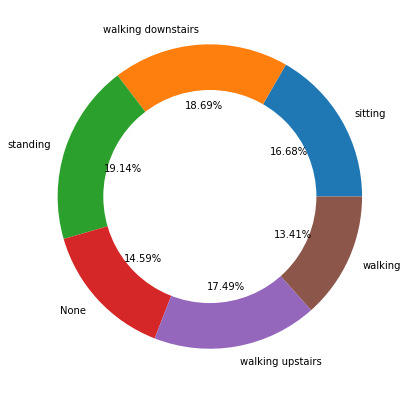

In [5]:
lol = pd.DataFrame(np.vectorize({1:'walking', 2:'walking upstairs', 3:'walking downstairs',
                           4:'sitting', 5:'standing', 6:'laying'}.get)(trainy), columns=['lol'])
fig = plt.gcf()
fig.set_size_inches(14, 7)

_=plt.pie(lol.groupby('lol').size(), labels=lol.lol.unique(), autopct="%1.2f%%")

# draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
_=fig.gca().add_artist(centre_circle)

## Fitting the model

#### LSTM

Initially, I'll be fitting an LSTM model on the data

In [6]:
trainy = to_categorical(trainy)
testy = to_categorical(testy)

In [7]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    epochs, batch_size = 15, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(100, input_shape = (n_timesteps, n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(n_outputs, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    m = model.fit(trainX, trainy, epochs = 15, batch_size = 64, verbose = 0)
    # evaluate model
    # _, accuracy = model.evaluate(testX, testy, batch_size = batch_size, verbose = 0)
    # return accuracy
    return m

In [48]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

model = Sequential()
model.add(LSTM(100, input_shape = (n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(n_outputs, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
m = model.fit(trainX, trainy, epochs = 30, batch_size = 64, verbose = 0)

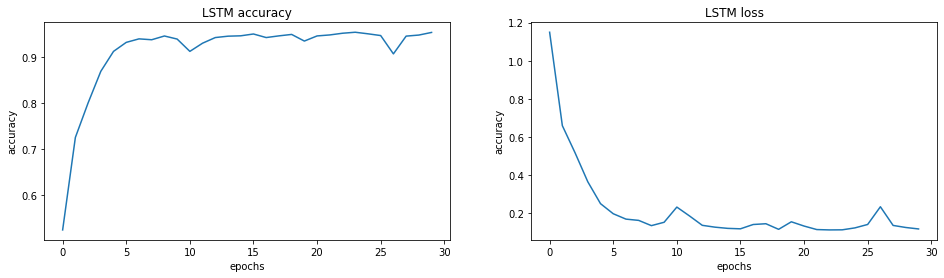

In [95]:
# evaluate model
_, accuracy = model.evaluate(testX, testy, batch_size = 64, verbose = 0)
print("accuracy : {}".format(accuracy))

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

my_accuracy = m.history['accuracy']
my_loss = m.history['loss']

_=ax[0].plot(my_accuracy)
_=ax[0].set_title('LSTM accuracy')
_=ax[0].set_xlabel('epochs')
_=ax[0].set_ylabel('accuracy')

_=ax[1].plot(my_loss)
_=ax[1].set_title('LSTM loss')
_=ax[1].set_xlabel('epochs')
_=ax[1].set_ylabel('accuracy')

As we can see, we were able to produce a good enough performance with LSTM with an accuracy of more than 90%. I tried to experiment with the number of epochs used in the training of the model, and it's interestin to note that after a certain number of epochs (around 7), the accuracy doesn't improve anymore and keeps fluctuating. We know that LSTM exploits the sequential structure of the data to improve its predictions, so as a benchmark, let's fit a regular MLP and see how the results differ when the underlying structure of the data is ignored.

#### MLP

In [84]:
sub_trainX = trainX[:,-1,:]
sub_testX = testX[:,-1,:]
n_features, n_outputs = trainX.shape[1], trainy.shape[1]

model2 = Sequential()
model2.add(Dense(20, input_dim=9, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(50, activation = 'relu'))
model2.add(Dense(n_outputs, activation = 'softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
m2 = model2.fit(sub_trainX, trainy, validation_data=(sub_testX, testy), epochs = 30, batch_size = 64, verbose = 0)

accuracy : 0.6664404273033142


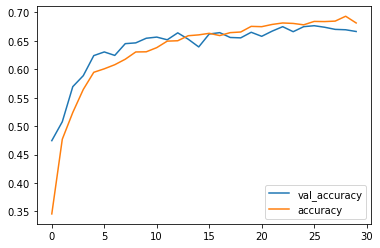

In [141]:
my_accuracy2 = m2.history['val_accuracy'][-1]
print("accuracy : {}".format(my_accuracy2))

_=plt.plot(m2.history['val_accuracy'], label='val_accuracy')
_=plt.plot(m2.history['accuracy'], label='accuracy')
_=plt.legend()

It's clear that the results produced by a regular MLP aren't as satisfactory as the previously fitted LSTM, proving that exploiting the underlying sequential structure of the data does in fact increase accuracy.

## Fitting models on extracted features

The previous models were fitted on the triaxial acceleration and estimated body acceleration from the accelerometer, as well as the triaxial angular velocity from the gyroscope. The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window), thus producing 561 features which contain time and frequency domain variables.

In [ ]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [185]:
path = "UCI HAR Dataset/UCI HAR Dataset/"

Xtrain_data = load_file(path + "train/X_train.txt")
ytrain_data = load_file(path + "train/y_train.txt")

Xtest_data = load_file(path + "test/X_test.txt")
ytest_data = load_file(path + "test/y_test.txt")

ytrain_data = to_categorical(ytrain_data-1)
ytest_data = to_categorical(ytest_data-1)

In [164]:
loss = []
accuracy = []
for i in range(10) :
    model3 = Sequential()
    model3.add(Dense(20, input_dim=561, activation='relu')) # 561 features
    model3.add(Dropout(0.5))
    model3.add(Dense(50, activation = 'relu'))
    model3.add(Dense(6, activation = 'softmax'))
    model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # fit network
    m3 = model3.fit(Xtrain_data, ytrain_data, validation_data=(Xtest_data, ytest_data),
                    epochs = 30, batch_size = 64, verbose = 0)
    
    # retrieve metrics
    loss.append(m3.history['val_loss'][-1])
    accuracy.append(m3.history['val_accuracy'][-1])

In [210]:
print("mean : {}".format(np.mean(accuracy)))
print("standard deviation : {}".format(np.std(accuracy)))

mean : 0.914048182964325
standard deviation : 0.07325622295360978


accuracy : 0.9297590851783752


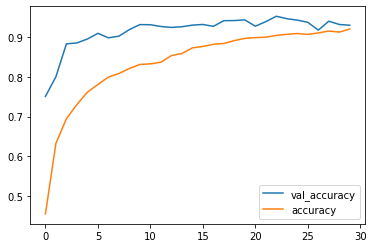

In [167]:
my_accuracy3 = m3.history['val_accuracy'][-1]
print("accuracy : {}".format(my_accuracy3))

_=plt.plot(m3.history['val_accuracy'], label='val_accuracy')
_=plt.plot(m3.history['accuracy'], label='accuracy')
_=plt.legend()